### Problem Statement

- Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.

- To evaluate tweets about multiple brands.
- Analysing the statement associated to a brand helps them in resolving the current issues and make better decisions.


### Dataset Description

- This dataset contains around 7k tweet text with the sentiment label.
- In dataset train.csv has 3 columns
    - tweet_id - Unique id for tweets. 
    - tweet - Tweet about the brand/product
    - sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell

In [41]:
import warnings 
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string
import collections
import matplotlib.cm as cm
from bs4 import BeautifulSoup
from plotly import graph_objs as go
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import unicodedata
import plotly.express as px
from collections import Counter
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Lemmatization
from nltk.stem import WordNetLemmatizer

### Reading data

In [2]:
TrainData=pd.read_csv('train.csv')
print('Shape of Train Data: ',TrainData.shape)
TestData=pd.read_csv('test.csv')
print('Shape of Test Data: ',TestData.shape)

Shape of Train Data:  (7274, 3)
Shape of Test Data:  (1819, 2)


So We have <b>7274</b> tweets in the <u>train</u> set and <b>1819</b> tweets in the <u>test</u> set

Lets check if any blank data available in train dataset

In [3]:
print("Train dataset")
TrainData[TrainData.isnull().any(axis = 1)]

Train dataset


tweet_id tweet  sentiment
1274         6   NaN          1

In [4]:
temp = TrainData.groupby('sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
print('sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Cant Tell')
temp.style.background_gradient(cmap='Accent_r')

sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Cant Tell


Looking into above raw data, we can say that we have large number of "Neutral" sentiment available so we can replace tweet blank data with text as "neutral"

In [5]:
# Replacing train tweet value
TrainData.fillna("neutral", inplace=True)

In [6]:
TrainData.isnull().count()
#TestData.isnull().count()

tweet_id     7274
tweet        7274
sentiment    7274
dtype: int64

Let's give proper sentiment name.

In [7]:
def getSentimentName(number):
    if number == 0:
        return 'Negative'
    if number == 1:
        return 'Neutral'
    if number == 2:
        return 'Positive'
    if number == 3:
        return 'Cant Tell'

In [8]:
TrainData['sentiment_name'] = TrainData['sentiment'].apply(lambda x: getSentimentName(x))

### EDA

In [9]:
TrainData.head()

tweet_id                                              tweet  sentiment  \
0      1701  #sxswnui #sxsw #apple defining language of tou...          1   
1      1851  Learning ab Google doodles! All doodles should...          1   
2      2689  one of the most in-your-face ex. of stealing t...          2   
3      4525  This iPhone #SXSW app would b pretty awesome i...          0   
4      3604  Line outside the Apple store in Austin waiting...          1   

  sentiment_name  
0        Neutral  
1        Neutral  
2       Positive  
3       Negative  
4        Neutral

Lets look at the distribution of tweets in the train set

Text(0.5, 1.0, 'Counts of Different Sentiments')

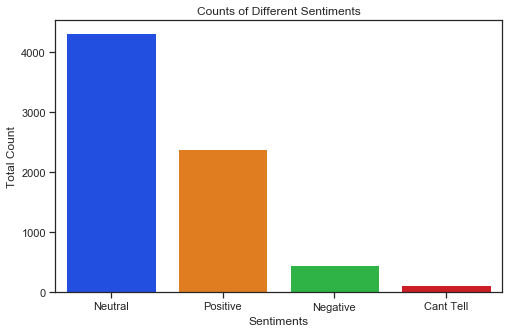

In [10]:
plt.figure(figsize=(8,5))
sns.set(style="ticks")
ax = sns.countplot(x = "sentiment_name",data = TrainData,palette="bright")
plt.xlabel("Sentiments")
plt.ylabel("Total Count")
plt.title("Counts of Different Sentiments")

In [11]:
# Function to show wordCloud using images
def generate_WordCloudWithImage(df_tweet,filename):
    plt.figure(figsize=(40,10))
    text = " ".join(tweet for tweet in df_tweet)
    custom_mask = np.array(Image.open("Images/T4.png"))
    wc = WordCloud(background_color="black",max_font_size=100,mask=custom_mask,max_words=100).generate(text)
    image_colors = ImageColorGenerator(custom_mask)
    wc.recolor(color_func=image_colors)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    wc.to_file(filename)
    plt.show()

# Function to show normal wordCloud
def generate_WordCloud(df_tweet,filename):
    text = " ".join(tweet for tweet in df_tweet)
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
    # Display the generated image:
    plt.figure(figsize=(8,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    wordcloud.to_file(filename)
    plt.show()

Let's first check the raw data

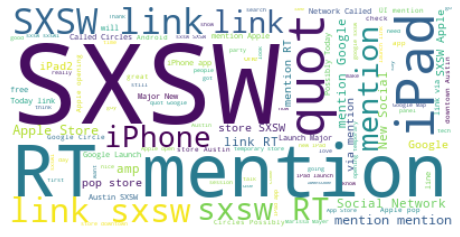

In [12]:
generate_WordCloud(TrainData['tweet'],"rawData.png")

Looking into above image we can say that the word "SXSW","mention","RT" are most use in our dataset.
we investigated about those words and we found below information.
- SXSW: <b>South by Southwest</b> music festivals and conferences organized in mid-March in Austin, Texas, United States
- RT: It's denote as Re-Tweet. It's polite Twitter etiquette to say someone 'Thank you'
- mention: Its' showing username anywhere in the body of the post.

### Data cleaning

In [13]:
#This function transforms all the accented characters into normal English .
# function to remove accented characters
def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text



# Cleaning @username, hash tag, date format, https links, normal links and numbers from the data.
def normalize_tweet(tweet):
    # Lower case the tweet
    tweet = tweet.lower()    
    #substitute link word
    tweet = re.sub('{link}', ' ', tweet)    
    # Remove &amp; words from data
    tweet = re.sub('&amp;|&quot;|&apos;|&gt;|&lt;|sxsw', ' ', tweet)
    # Substitute mentions
    tweet = re.sub('@\w+', ' ', tweet)    
    # Substitute hashtags
    tweet = re.sub('#\w+', ' ', tweet)             
    # Substitute numbers
    tweet = re.sub('[0-9]', ' ', tweet)
    # Remove http links
    tweet = re.sub(r'http\S+', ' ', tweet)
    # Remove punctuation
    tweet = re.sub('[%s]' % re.escape(string.punctuation), ' ', tweet)
    # Remove new line words
    tweet = re.sub('\n', '', tweet)
    
    return tweet

def normalize_tweet2(tweet):
      
    # Remove &amp; words from data
    tweet = re.sub('&amp;|&quot;|&apos;|&gt;|&lt;|sxsw', ' ', tweet)   
    # Substitute hashtags
    tweet = re.sub('#', ' ', tweet)             
    # Substitute numbers
    tweet = re.sub('[0-9]', ' ', tweet)
    # Remove http links
    tweet = re.sub(r'http\S+', ' ', tweet)
    # Remove punctuation
    tweet = re.sub('[%s]' % re.escape(string.punctuation), ' ', tweet)
    # Remove new line words
    tweet = re.sub('\n', '', tweet)
    
    return tweet

# Remove HTML tags
def remove_html_tags(tweet):
    return BeautifulSoup(tweet, 'html.parser').get_text()


# Remove words less than or qual to 2 characters.
def Remove_short_words(text):
    word1=word_tokenize(text.lower())
    word2= ' '.join(word for word in word1 if len(word)>2)        
    
    return word2

def Remove_short_words2(text):
    word1=word_tokenize(text.lower())
    word2= ' '.join(word for word in word1 if len(word)>1)        
    
    return word2

In [14]:
TrainData['clean_text'] = TrainData['tweet'].apply(remove_accented_chars)
TrainData['clean_text'] = TrainData['clean_text'].map(normalize_tweet)
TrainData['clean_text'] = TrainData['clean_text'].apply(remove_html_tags)
TrainData['clean_text'] = TrainData['clean_text'].apply(Remove_short_words)

In [15]:
TrainData.head()

tweet_id                                              tweet  sentiment  \
0      1701  #sxswnui #sxsw #apple defining language of tou...          1   
1      1851  Learning ab Google doodles! All doodles should...          1   
2      2689  one of the most in-your-face ex. of stealing t...          2   
3      4525  This iPhone #SXSW app would b pretty awesome i...          0   
4      3604  Line outside the Apple store in Austin waiting...          1   

  sentiment_name                                         clean_text  
0        Neutral  nui defining language touch with different dia...  
1        Neutral  learning google doodles all doodles should lig...  
2       Positive  one the most your face stealing the show yrs a...  
3       Negative  this iphone app would pretty awesome didn cras...  
4        Neutral  line outside the apple store austin waiting fo...

In [16]:
TrainData.to_excel("CreatedFile/outputR1.xlsx")

### Most Common words in our clean_text

In [17]:
TrainData['temp_list'] = TrainData['clean_text'].apply(lambda x:str(x).split())

top = Counter([item for sublist in TrainData['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

Looking into above most table it's look like we haven't remove stopwords from our dataset. 
Let's remove Stopwords.
- What is stopwords - the words which does not have any much meaning in given sentences. like, the, for, and, you ect.

In [18]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]

TrainData['temp_list'] = TrainData['temp_list'].apply(lambda x:remove_stopword(x))

In [20]:
top = Counter([item for sublist in TrainData['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

We can see the top 10 most use words in our dataset here. let's try on another visualisation 

In [21]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

## Most common words Sentiments Wise

Let's look at the most common words in different sentiments

In [22]:
Positive_sent = TrainData[TrainData['sentiment']==2]
Negative_sent = TrainData[TrainData['sentiment']==0]
Neutral_sent  = TrainData[TrainData['sentiment']==1]
CantSay_sent  = TrainData[TrainData['sentiment']==3]

#### Top 10 common Positive Sentiment word 

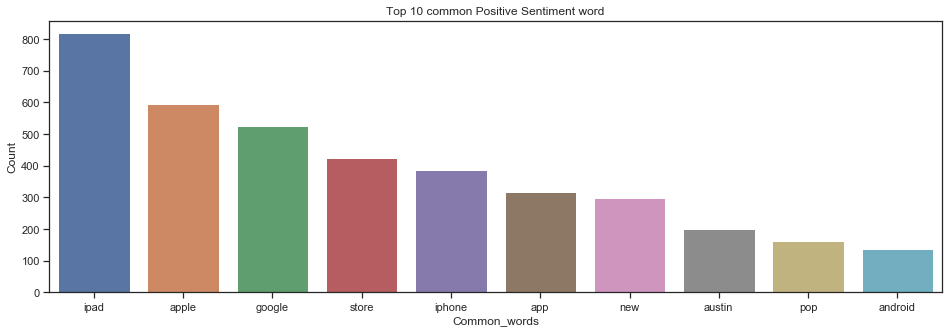

In [23]:
# MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

sns.set(style="ticks")
plt.figure(figsize=(16,5))
ax = sns.barplot(data=temp_positive, x= "Common_words", y = "count")
ax.set(ylabel = 'Count')
plt.title("Top 10 common Positive Sentiment word")
plt.show()

#### Top 10 common Negative Sentiment word 

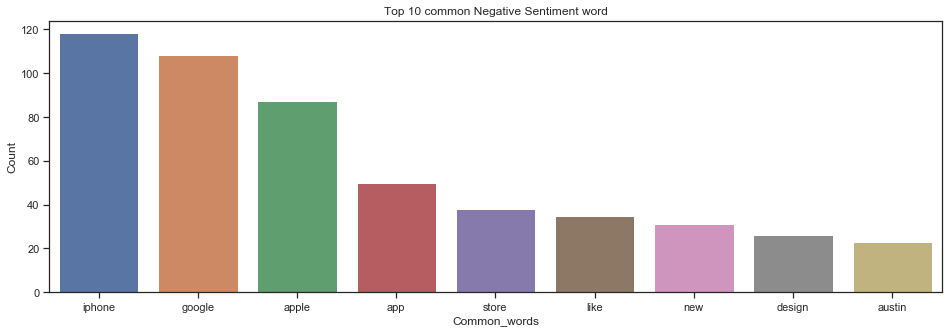

In [24]:
# MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(10))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

plt.figure(figsize=(16,5))
ax = sns.barplot(data=temp_negative, x= "Common_words", y = "count")
ax.set(ylabel = 'Count')
plt.title("Top 10 common Negative Sentiment word")
plt.show()

#### Top 10 common Neutral Sentiment word 

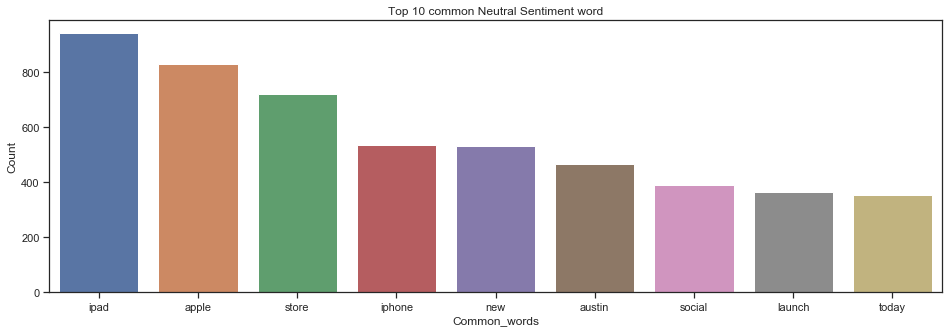

In [25]:
# Most common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(10))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Oranges')

plt.figure(figsize=(16,5))
ax = sns.barplot(data=temp_neutral, x= "Common_words", y = "count")
ax.set(ylabel = 'Count')
plt.title("Top 10 common Neutral Sentiment word")
plt.show()

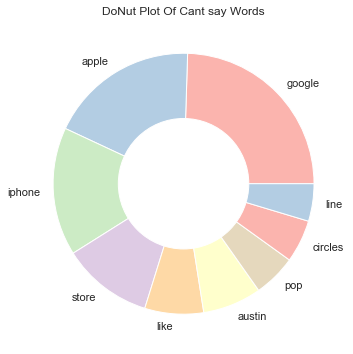

In [26]:
# Most common Can't say words
top = Counter([item for sublist in CantSay_sent['temp_list'] for item in sublist])
temp_cantSay = pd.DataFrame(top.most_common(10))
temp_cantSay = temp_cantSay.loc[1:,:]
temp_cantSay.columns = ['Common_words','count']
temp_cantSay.style.background_gradient(cmap='Purples')

#!pip install palettable
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(12,6))
my_circle=plt.Circle((0,0), 0.5, color='white')
plt.pie(temp_cantSay['count'], labels=temp_cantSay.Common_words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Cant say Words')
plt.show()

## Let's check what hashtag value showing in our dataset

In [27]:
# Function extract hashtags value
def hashtag_extract(tweet):
    hashtags = []    
    x=tweet.split()
    for i in x:
        if re.match(r'^#', i):
            hashtags.append(i)
    hashtags=" ".join(word for word in hashtags)
    return hashtags.lower()

In [28]:
TrainData['hash_tag'] = TrainData['tweet'].apply(hashtag_extract)

In [29]:
TrainData.to_excel("CreatedFile/HashTags.xlsx")

In [30]:
TrainData.head()

tweet_id                                              tweet  sentiment  \
0      1701  #sxswnui #sxsw #apple defining language of tou...          1   
1      1851  Learning ab Google doodles! All doodles should...          1   
2      2689  one of the most in-your-face ex. of stealing t...          2   
3      4525  This iPhone #SXSW app would b pretty awesome i...          0   
4      3604  Line outside the Apple store in Austin waiting...          1   

  sentiment_name                                         clean_text  \
0        Neutral  nui defining language touch with different dia...   
1        Neutral  learning google doodles all doodles should lig...   
2       Positive  one the most your face stealing the show yrs a...   
3       Negative  this iphone app would pretty awesome didn cras...   
4        Neutral  line outside the apple store austin waiting fo...   

                                           temp_list  \
0  [nui, defining, language, touch, different, di...   
1  [learning, google, doodles, doodles, light, fu...   
2  [one, face, stealing, show, yrs, apple, school...   
3  [iphone, app, would, pretty, awesome, crash, e...   
4  [line, outside, apple, store, austin, waiting,...   

                       hash_tag  
0         #sxswnui #sxsw #apple  
1           #googledoodle #sxsw  
2                        #sxsw,  
3  #sxsw #fuckit #illmakeitwork  
4                         #sxsw

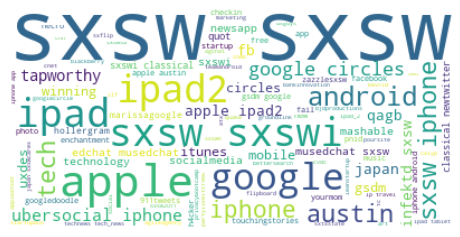

In [31]:
generate_WordCloud(TrainData['hash_tag'],'hashTag.png')

Looking into above image we can say that the word "SXSW" are most #tag used. Can we remove it from our dataset and check which words are using users for hash tags

In [32]:
TrainData['hash_tag'] = TrainData['hash_tag'].apply(remove_accented_chars)
TrainData['hash_tag'] = TrainData['hash_tag'].map(normalize_tweet2)
TrainData['hash_tag'] = TrainData['hash_tag'].apply(remove_html_tags)
TrainData['hash_tag'] = TrainData['hash_tag'].apply(Remove_short_words2)

In [33]:
all_headlines = ' '.join(TrainData['hash_tag'])
all_headlines_neg = ' '.join(TrainData[TrainData["sentiment"]==0]['hash_tag'])
all_headlines_pos = ' '.join(TrainData[TrainData["sentiment"]==2]['hash_tag'])
all_headlines_neu = ' '.join(TrainData[TrainData["sentiment"]==1]['hash_tag'])

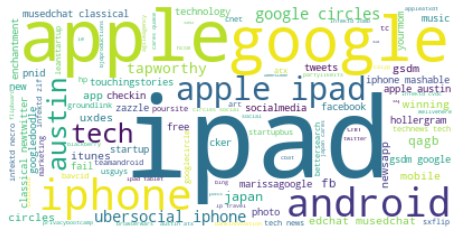

In [34]:
generate_WordCloud(TrainData['hash_tag'],'Overall_hashTag.png')

### Positive most common hash tag word

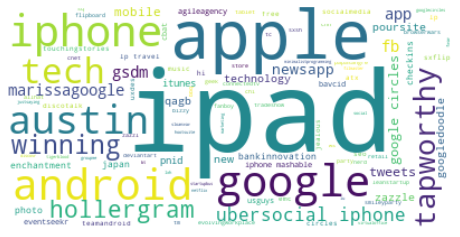

In [35]:
generate_WordCloud(TrainData[TrainData["sentiment"]==2]['hash_tag'],'Positive_hashTag.png')

### Nagative most common hash tag word

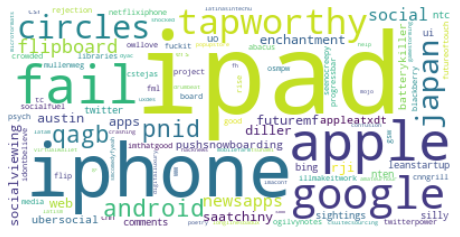

In [36]:
generate_WordCloud(TrainData[TrainData["sentiment"]==0]['hash_tag'],'Nagative_hashTag.png')

In [37]:
#Addition graphs for further analysis
# fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
# fig.show()
#generate_WordCloudWithImage(TrainData['tweet'],'tweet.png')

Regarding "Hastag" words we can see that the word 'ipad','apple','anroid' most <b>positive sentiment</b> words used. also, the words 'ipad','apple','iphone','google','fail' those are <b>Negative sentiment</b> words has been used.

# Model building

In [38]:
from sklearn import metrics
from sklearn.metrics import f1_score

Model building on clean data

In [66]:
X = TrainData['clean_text']
y = TrainData['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

In [68]:
cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train)
X_test_vec = cv.transform(X_test)

In [61]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = LinearSVC(random_state=1)
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2),('lsv',clf3)], voting='hard')

In [104]:
eclf1 = eclf1.fit(X_train_vec, y_train)
y_pred=eclf1.predict(X_test_vec)
f1_scoreVS=metrics.f1_score(y_test, y_pred, average='weighted')
print("Voting Classifier")
print("F1 score: ",f1_scoreVS)
#print(classification_report(y_test, y_pred))

Voting Classifier
F1 score:  0.6724288748546942


In [105]:
clf1 = clf1.fit(X_train_vec,y_train)
y_pred=clf1.predict(X_test_vec)
f1_scoreLR=metrics.f1_score(y_test, y_pred, average='weighted')
print("Logistic Regression")
print("F1 score: ",f1_scoreLR)

Logistic Regression
F1 score:  0.6678251170875549


In [106]:
clf2 = clf2.fit(X_train_vec,y_train)
y_pred=clf2.predict(X_test_vec)
f1_scoreRC=metrics.f1_score(y_test, y_pred, average='weighted')
print("RandomForest Classifier")
print("F1 score: ",f1_scoreRC)

RandomForest Classifier
F1 score:  0.6493711565719579


In [107]:
clf3 = clf3.fit(X_train_vec,y_train)
y_pred=clf3.predict(X_test_vec)
f1_scoreSVC=metrics.f1_score(y_test, y_pred, average='weighted')
print("LinearSVC")
print("F1 score: ",f1_scoreSVC)

LinearSVC
F1 score:  0.6634710259121105


In [108]:
print("Voting Classifier: ",f1_scoreVS)
print("Logistic Regression: ",f1_scoreLR)
print("RandomForest Classifier: ",f1_scoreRC)
print("LinearSVC: ",f1_scoreSVC)

Voting Classifier:  0.6724288748546942
Logistic Regression:  0.6678251170875549
RandomForest Classifier:  0.6493711565719579
LinearSVC:  0.6634710259121105


As per the above model building we can say that "Logistics Regression" best fit for this model

###### Test data

In [84]:
TestData = pd.read_csv('test.csv')

In [85]:
print(TestData.shape)
TestData.info()
TestData.count()

(1819, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 2 columns):
tweet_id    1819 non-null int64
tweet       1819 non-null object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


tweet_id    1819
tweet       1819
dtype: int64

In [86]:
TestData['clean_text'] = TestData['tweet'].apply(remove_accented_chars)
TestData['clean_text'] = TestData['clean_text'].map(normalize_tweet)
TestData['clean_text'] = TestData['clean_text'].apply(remove_html_tags)
TestData['clean_text'] = TestData['clean_text'].apply(Remove_short_words)

In [88]:
TestData.head()

tweet_id                                              tweet  \
0      7506  Audience Q: What prototyping tools do you use?...   
1      7992  At SXSW? Send Your Best Photos &amp; Videos to...   
2       247  @mention  and here's a pic of you winning your...   
3      7688  Google Marissa Mayer: mobile phone as a cursor...   
4      3294    #SXSW Google maps is even cooler than I thought   

                                          clean_text  
0  audience what prototyping tools you use sketch...  
1                       send your best photos videos  
2            and here pic you winning your ipad cont  
3  google marissa mayer mobile phone cursor physi...  
4               google maps even cooler than thought

In [100]:
training_data , testing_data = train_test_split(TrainData,random_state = 2000)

Y_train=training_data['sentiment'].values
Y_test=testing_data['sentiment'].values

cv= CountVectorizer()
cv.fit_transform(TrainData['clean_text'].values)

X_train=cv.transform(training_data['clean_text'].values)
X_test=cv.transform(testing_data['clean_text'].values)    

reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
data1=pd.DataFrame(X_train)
model=reg.fit(X_train,Y_train)
Y_pred = reg.predict(X_test)

[LibLinear]

In [101]:
# now work on test file

X_test_2=cv.transform(TestData['clean_text'].values) 

data2=pd.DataFrame(X_test_2)

Y_pred_2 = reg.predict(X_test_2)

test_tweet_ids=TestData['tweet_id']
pd.DataFrame(data={ 'tweet_id': test_tweet_ids, 'sentiment': Y_pred_2}).to_csv('CreatedFile/sample_submission.csv')